# Estratégia de Preenchimento de Gaps - Dados de Vento SODAR

## Objetivo
Criar um dataset unificado e contínuo para treinamento de modelos de previsão de velocidade do vento, resolvendo:
1. **Valores nulos** por falha do sensor
2. **Gaps temporais** de 4-10 dias que tornam a série descontínua

## Estratégia Multi-Layered

### 1. Análise de Gaps
- Classificar gaps por duração (curtos: <4h, médios: 4h-2dias, longos: >2dias)
- Identificar padrões temporais nos gaps
- Análise de autocorrelação para definir estratégias de preenchimento

### 2. Preenchimento Hierárquico
- **Gaps curtos (<4h)**: Interpolação linear/spline + Kalman Filter
- **Gaps médios (4h-2dias)**: Seasonal decomposition + padrões históricos
- **Gaps longos (>2dias)**: Modelos climáticos + dados meteorológicos externos

### 3. Validação e Qualidade
- Cross-validation com dados conhecidos
- Métricas de qualidade para cada tipo de preenchimento
- Bandas de confiança para valores imputados

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para preenchimento de gaps
from scipy import interpolate
from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.structural import UnobservedComponents as UC
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuração
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

print("✓ Bibliotecas importadas com sucesso")

✓ Bibliotecas importadas com sucesso


## 1. Carregar e Analisar Datasets Fragmentados

In [174]:
# Definir diretórios
filtered_data_dir = Path("../filtered_csv_data")
output_dir = Path("../clean_data")
output_dir.mkdir(exist_ok=True)

# Carregar todos os datasets fragmentados
csv_files = sorted(filtered_data_dir.glob("WS100_*.csv"))
datasets = []

print(f"=== Carregando {len(csv_files)} datasets fragmentados ===")

for file_path in csv_files:
    df = pd.read_csv(file_path, index_col='DT', parse_dates=True)
    datasets.append({
        'name': file_path.name,
        'data': df,
        'start': df.index[0],
        'end': df.index[-1],
        'duration_hours': (df.index[-1] - df.index[0]).total_seconds() / 3600,
        'records': len(df),
        'valid_values': df['SODAR-100'].notna().sum(),
        'null_ratio': df['SODAR-100'].isna().sum() / len(df)
    })
    print(f"✓ {file_path.name}: {len(df)} registros ({df.index[0]} até {df.index[-1]})")

print(f"\n=== Resumo dos Datasets ===")
total_records = sum(d['records'] for d in datasets)
total_valid = sum(d['valid_values'] for d in datasets)
overall_period = (datasets[-1]['end'] - datasets[0]['start']).days

print(f"Total de arquivos: {len(datasets)}")
print(f"Período total: {datasets[0]['start']} até {datasets[-1]['end']} ({overall_period} dias)")
print(f"Total de registros: {total_records:,}")
print(f"Valores válidos: {total_valid:,} ({total_valid/total_records*100:.1f}%)")

=== Carregando 22 datasets fragmentados ===
✓ WS100_20211110_to_20211113.csv: 351 registros (2021-11-10 17:20:00 até 2021-11-13 03:40:00)
✓ WS100_20211113_to_20211202.csv: 2787 registros (2021-11-13 08:10:00 até 2021-12-02 20:40:00)
✓ WS100_20211203_to_20220121.csv: 7039 registros (2021-12-03 01:10:00 até 2022-01-21 04:40:00)
✓ WS100_20220121_to_20220219.csv: 4084 registros (2022-01-21 12:00:00 até 2022-02-19 03:20:00)
✓ WS100_20220220_to_20220223.csv: 433 registros (2022-02-20 00:10:00 até 2022-02-23 00:30:00)
✓ WS100_20220225_to_20220305.csv: 1086 registros (2022-02-25 10:40:00 até 2022-03-05 00:20:00)
✓ WS100_20220306_to_20220308.csv: 311 registros (2022-03-06 00:10:00 até 2022-03-08 11:40:00)
✓ WS100_20220309_to_20220311.csv: 364 registros (2022-03-09 00:10:00 até 2022-03-11 17:50:00)
✓ WS100_20220311_to_20220315.csv: 486 registros (2022-03-11 22:30:00 até 2022-03-15 10:00:00)
✓ WS100_20220315.csv: 29 registros (2022-03-15 15:20:00 até 2022-03-15 23:40:00)
✓ WS100_20220316_to_20220

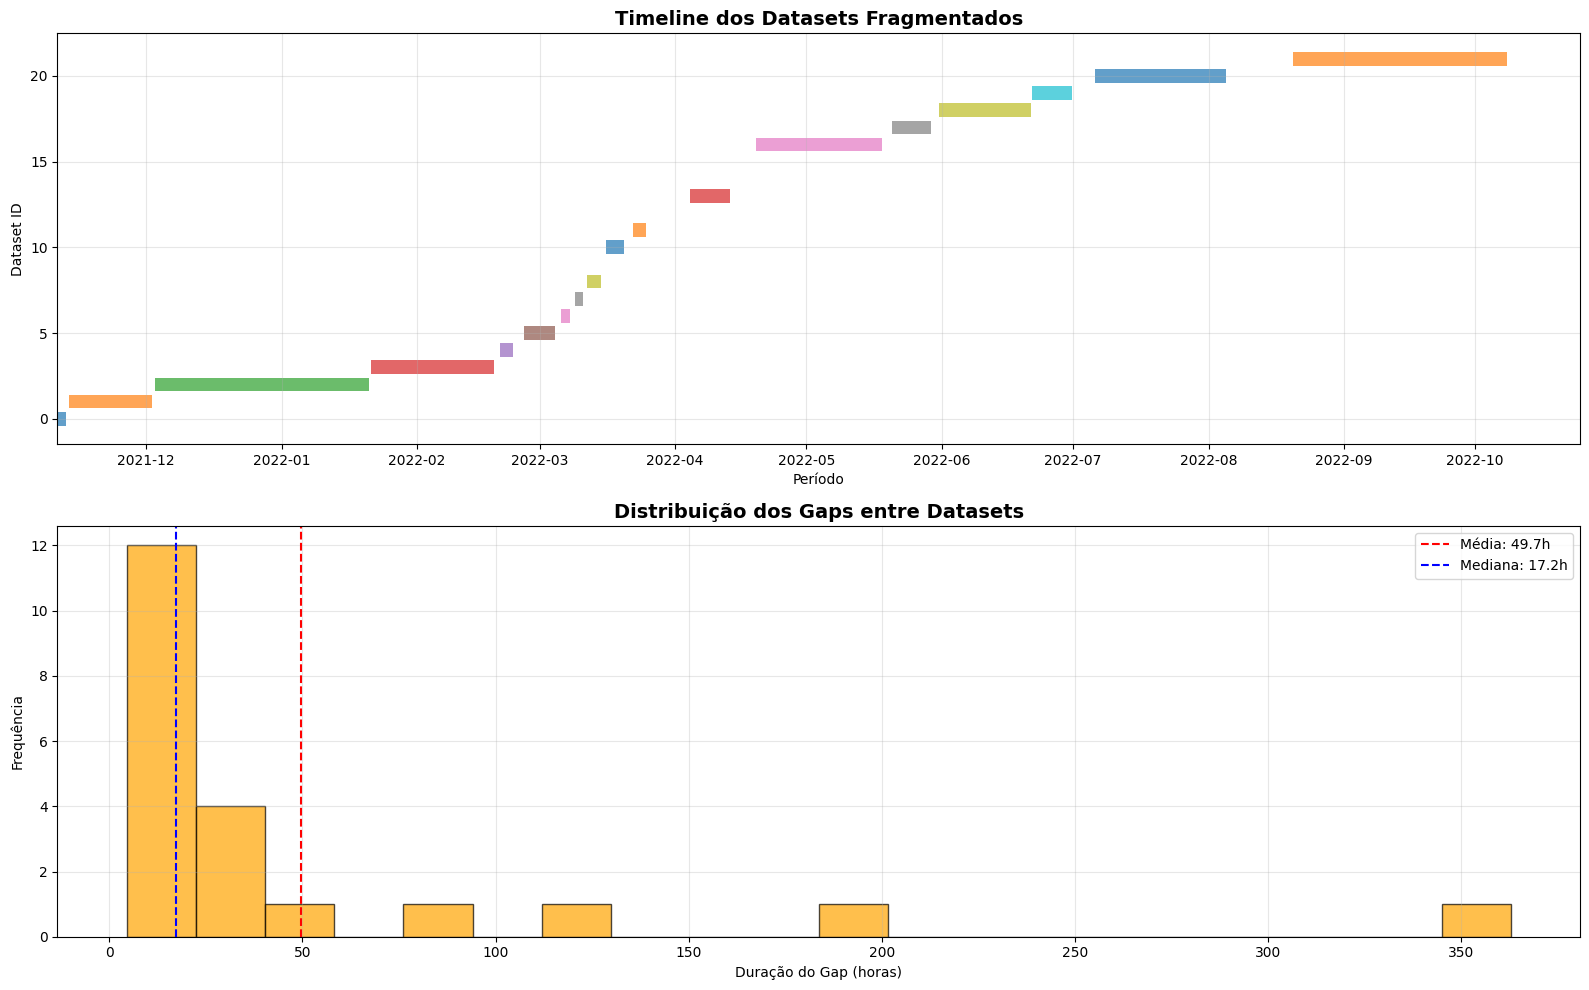


=== Análise de Gaps entre Datasets ===
Gaps encontrados: 21
Gap mínimo: 4.5 horas
Gap máximo: 362.8 horas
Gap médio: 49.7 horas
Gaps > 24h: 7
Gaps > 168h (1 semana): 2


In [175]:
# Visualizar timeline dos datasets
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Timeline dos datasets
for i, dataset in enumerate(datasets):
    start = dataset['start']
    end = dataset['end']
    ax1.barh(i, (end - start).days, left=start, alpha=0.7, 
             label=f"{dataset['name'][:15]}..." if len(dataset['name']) > 15 else dataset['name'])

ax1.set_title('Timeline dos Datasets Fragmentados', fontsize=14, fontweight='bold')
ax1.set_ylabel('Dataset ID')
ax1.set_xlabel('Período')
ax1.grid(True, alpha=0.3)

# Análise de gaps entre datasets
gaps_between_datasets = []
for i in range(len(datasets) - 1):
    current_end = datasets[i]['end']
    next_start = datasets[i + 1]['start']
    gap_hours = (next_start - current_end).total_seconds() / 3600
    gaps_between_datasets.append(gap_hours)

# Histograma dos gaps
if gaps_between_datasets:
    ax2.hist(gaps_between_datasets, bins=20, alpha=0.7, color='orange', edgecolor='black')
    ax2.set_title('Distribuição dos Gaps entre Datasets', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Duração do Gap (horas)')
    ax2.set_ylabel('Frequência')
    ax2.axvline(np.mean(gaps_between_datasets), color='red', linestyle='--', 
               label=f'Média: {np.mean(gaps_between_datasets):.1f}h')
    ax2.axvline(np.median(gaps_between_datasets), color='blue', linestyle='--', 
               label=f'Mediana: {np.median(gaps_between_datasets):.1f}h')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Análise de Gaps entre Datasets ===")
print(f"Gaps encontrados: {len(gaps_between_datasets)}")
if gaps_between_datasets:
    print(f"Gap mínimo: {min(gaps_between_datasets):.1f} horas")
    print(f"Gap máximo: {max(gaps_between_datasets):.1f} horas")
    print(f"Gap médio: {np.mean(gaps_between_datasets):.1f} horas")
    print(f"Gaps > 24h: {sum(1 for g in gaps_between_datasets if g > 24)}")
    print(f"Gaps > 168h (1 semana): {sum(1 for g in gaps_between_datasets if g > 168)}")

In [176]:
# Diagnóstico de duplicatas nos datasets
print("=== Diagnóstico de Duplicatas ===")
total_duplicates = 0
overlaps = []

for i, dataset in enumerate(datasets):
    df = dataset['data']
    duplicates_in_dataset = df.index.duplicated().sum()
    if duplicates_in_dataset > 0:
        print(f"⚠️  {dataset['name']}: {duplicates_in_dataset} timestamps duplicados")
        total_duplicates += duplicates_in_dataset
    
    # Verificar sobreposições entre datasets consecutivos
    if i > 0:
        prev_dataset = datasets[i-1]
        overlap_start = max(prev_dataset['start'], dataset['start'])
        overlap_end = min(prev_dataset['end'], dataset['end'])
        
        if overlap_start < overlap_end:
            overlap_hours = (overlap_end - overlap_start).total_seconds() / 3600
            overlaps.append({
                'dataset1': prev_dataset['name'],
                'dataset2': dataset['name'],
                'overlap_hours': overlap_hours,
                'overlap_start': overlap_start,
                'overlap_end': overlap_end
            })
            print(f"🔄 Sobreposição: {prev_dataset['name']} ↔ {dataset['name']} = {overlap_hours:.1f}h")

print(f"\nTotal de duplicatas encontradas: {total_duplicates}")
print(f"Total de sobreposições entre datasets: {len(overlaps)}")

if overlaps:
    print(f"\nDetalhes das sobreposições:")
    for overlap in overlaps:
        print(f"  {overlap['dataset1']} ↔ {overlap['dataset2']}")
        print(f"    Período: {overlap['overlap_start']} até {overlap['overlap_end']}")
        print(f"    Duração: {overlap['overlap_hours']:.1f} horas")

print("✓ Diagnóstico concluído - as duplicatas serão tratadas na consolidação")

=== Diagnóstico de Duplicatas ===
⚠️  WS100_20220621_to_20220701.csv: 95 timestamps duplicados

Total de duplicatas encontradas: 95
Total de sobreposições entre datasets: 0
✓ Diagnóstico concluído - as duplicatas serão tratadas na consolidação


## 2. Criar Timeline Completa e Classificar Gaps

In [177]:
def create_complete_timeline(datasets, frequency='10min'):
    """
    Cria uma timeline completa desde o primeiro até o último dataset
    com frequência especificada (10min para dados SODAR)
    """
    start_time = datasets[0]['start']
    end_time = datasets[-1]['end']
    
    # Criar índice temporal completo
    complete_index = pd.date_range(start=start_time, end=end_time, freq=frequency)
    
    # Criar DataFrame com valores NaN
    complete_df = pd.DataFrame(index=complete_index, columns=['SODAR-100'])
    complete_df['SODAR-100'] = np.nan
    complete_df['data_source'] = 'missing'  # Flag para identificar origem dos dados
    
    # Primeiro, consolidar todos os dados em um único DataFrame para lidar com duplicatas
    all_data = []
    for dataset in datasets:
        df = dataset['data'].copy()
        df['dataset_name'] = dataset['name']
        all_data.append(df)
    
    # Concatenar todos os dados
    consolidated_data = pd.concat(all_data, ignore_index=False)
    
    # Remover duplicatas, mantendo o último valor (mais recente)
    # Primeiro, resetar o índice para poder trabalhar com duplicatas
    consolidated_data_reset = consolidated_data.reset_index()
    consolidated_data_reset = consolidated_data_reset.drop_duplicates(subset=['DT'], keep='last')
    consolidated_data_clean = consolidated_data_reset.set_index('DT')
    
    print(f"✓ Dados consolidados: {len(consolidated_data)} -> {len(consolidated_data_clean)} (após remoção de duplicatas)")
    
    # Agora preencher a timeline completa com os dados limpos
    common_index = complete_df.index.intersection(consolidated_data_clean.index)
    complete_df.loc[common_index, 'SODAR-100'] = consolidated_data_clean.loc[common_index, 'SODAR-100']
    complete_df.loc[common_index, 'data_source'] = 'original'
    
    return complete_df

# Criar timeline completa
complete_timeline = create_complete_timeline(datasets)

print(f"=== Timeline Completa Criada ===")
print(f"Período: {complete_timeline.index[0]} até {complete_timeline.index[-1]}")
print(f"Total de pontos: {len(complete_timeline):,}")
print(f"Dados originais: {(complete_timeline['data_source'] == 'original').sum():,}")
print(f"Dados faltantes: {(complete_timeline['data_source'] == 'missing').sum():,}")
print(f"Taxa de completude: {(complete_timeline['data_source'] == 'original').sum() / len(complete_timeline) * 100:.1f}%")

✓ Dados consolidados: 41074 -> 40979 (após remoção de duplicatas)
=== Timeline Completa Criada ===
Período: 2021-11-10 17:20:00 até 2022-10-09 08:30:00
Total de pontos: 47,900
Dados originais: 40,979
Dados faltantes: 6,921
Taxa de completude: 85.6%


In [178]:
def classify_gaps(df, value_col='SODAR-100'):
    """
    Classifica gaps por duração e características
    """
    # Verificar se é Series ou DataFrame
    if isinstance(df, pd.Series):
        data_series = df
    else:
        # Verificar se a coluna existe
        if value_col not in df.columns:
            print(f"⚠️  Coluna '{value_col}' não encontrada. Colunas disponíveis: {df.columns.tolist()}")
            return []
        data_series = df[value_col]
    
    # Identificar períodos de dados faltantes
    is_missing = data_series.isna()
    
    # Se não há dados faltantes, retornar lista vazia
    if not is_missing.any():
        print("✓ Nenhum gap encontrado - série temporal completa")
        return []
    
    missing_diff = is_missing.astype(int).diff().fillna(0)
    
    # Encontrar início e fim dos gaps
    gap_starts = data_series.index[missing_diff == 1].tolist()
    gap_ends = data_series.index[missing_diff == -1].tolist()
    
    # Ajustar se a série começar ou terminar com NaN
    if is_missing.iloc[0]:
        gap_starts.insert(0, data_series.index[0])
    if is_missing.iloc[-1]:
        gap_ends.append(data_series.index[-1])
    
    # Verificar consistência
    if len(gap_starts) != len(gap_ends):
        print(f"⚠️  Inconsistência: {len(gap_starts)} inícios vs {len(gap_ends)} fins de gaps")
        # Tentar corrigir
        min_len = min(len(gap_starts), len(gap_ends))
        gap_starts = gap_starts[:min_len]
        gap_ends = gap_ends[:min_len]
    
    # Classificar gaps
    gap_classifications = []
    
    for start, end in zip(gap_starts, gap_ends):
        try:
            duration_hours = (end - start).total_seconds() / 3600
            
            # Contar pontos no gap de forma mais segura
            try:
                gap_slice = data_series.loc[start:end]
                duration_points = len(gap_slice)
            except:
                # Fallback: estimar baseado na duração e frequência
                duration_points = int(duration_hours * 6)  # 6 pontos por hora (10min)
            
            # Classificação por duração
            if duration_hours <= 4:
                gap_type = 'short'  # Curto: <= 4 horas
            elif duration_hours <= 48:
                gap_type = 'medium'  # Médio: 4h - 2 dias
            else:
                gap_type = 'long'  # Longo: > 2 dias
            
            gap_classifications.append({
                'start': start,
                'end': end,
                'duration_hours': duration_hours,
                'duration_points': duration_points,
                'type': gap_type
            })
        except Exception as e:
            print(f"⚠️  Erro ao processar gap {start} até {end}: {e}")
            continue
    
    return gap_classifications

## 3. Análise de Padrões Temporais

=== Análise de Padrões nos Dados Válidos ===
Dados válidos: 40,979 pontos
Período dos dados válidos: 2021-11-10 17:20:00 até 2022-10-09 08:30:00
Estatísticas básicas:
count    40979.000000
mean         7.305334
std          2.577671
min          0.070000
25%          5.560000
50%          7.380000
75%          9.150000
max         32.490000
Name: SODAR-100, dtype: float64

=== Autocorrelação Temporal ===
Lag 1h: 0.819
Lag 6h: 0.560
Lag 12h: 0.503
Lag 24h: 0.539
Lag 72h: 0.454
Lag 168h: 0.372


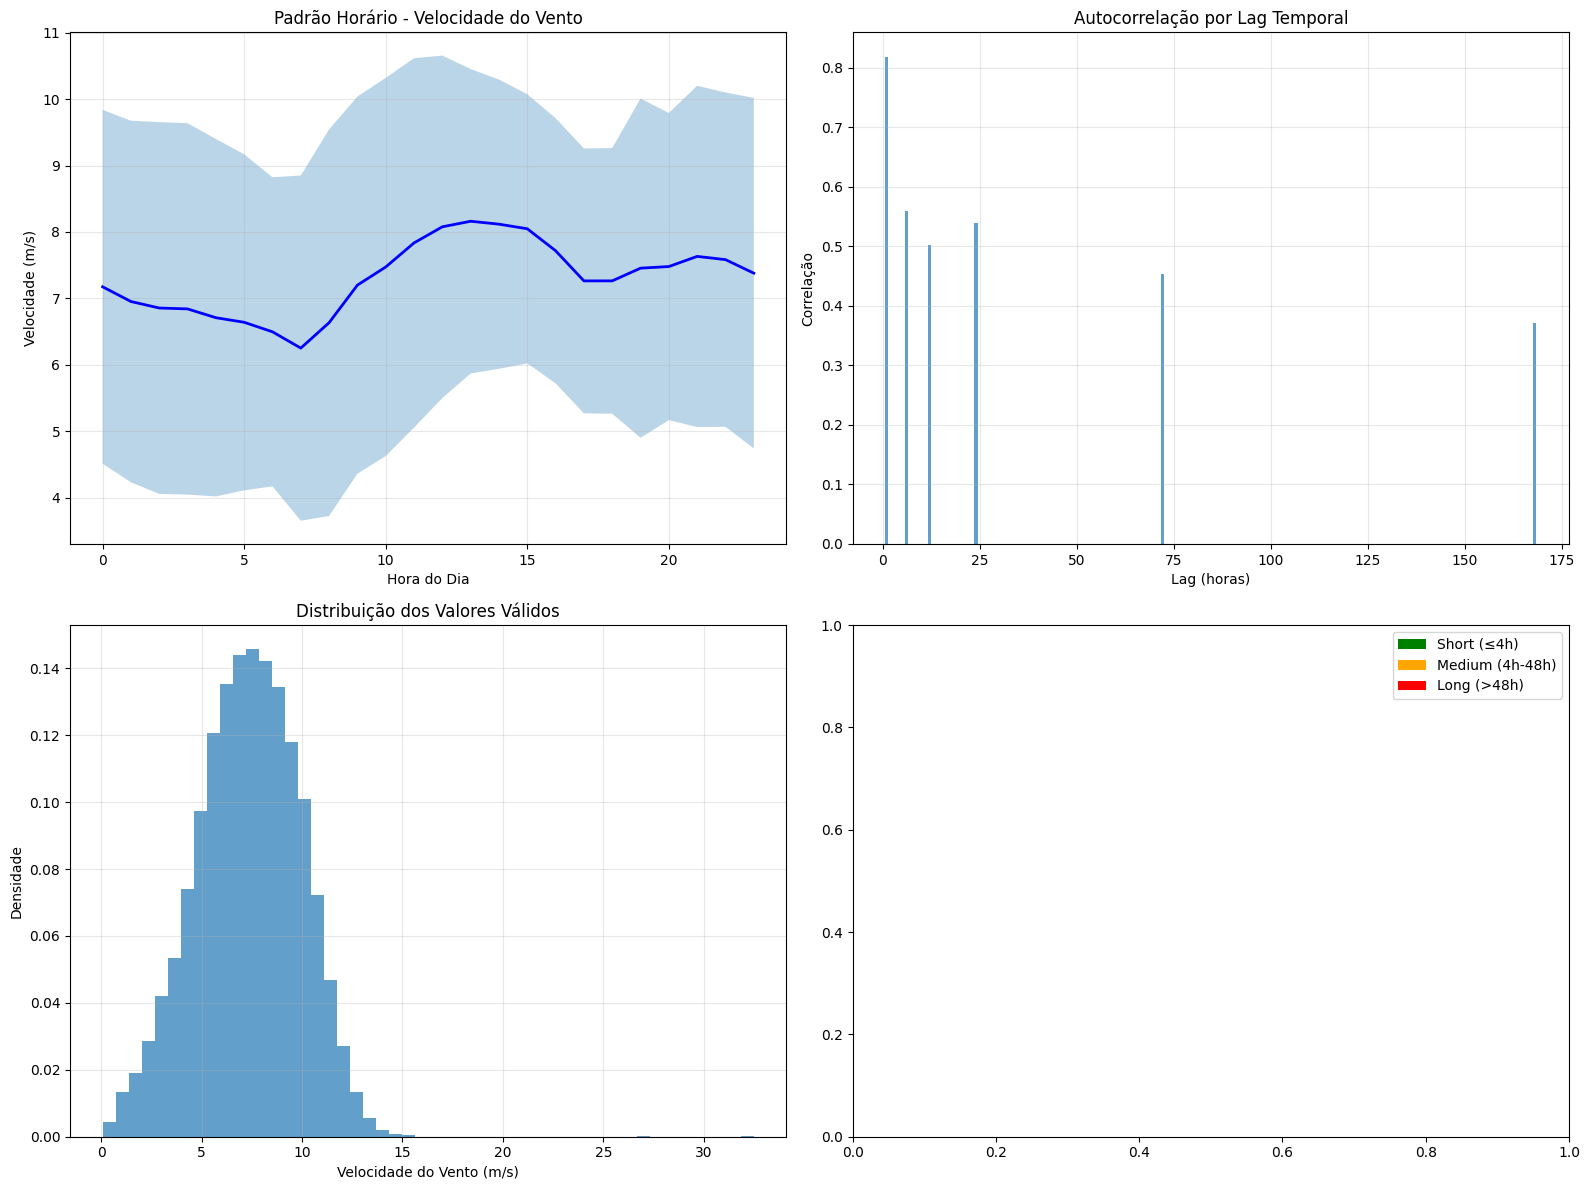

In [179]:
# Analisar padrões nos dados existentes
valid_data = complete_timeline[complete_timeline['data_source'] == 'original']['SODAR-100'].dropna()

print(f"=== Análise de Padrões nos Dados Válidos ===")
print(f"Dados válidos: {len(valid_data):,} pontos")
print(f"Período dos dados válidos: {valid_data.index[0]} até {valid_data.index[-1]}")
print(f"Estatísticas básicas:")
print(valid_data.describe())

# Análise de autocorrelação
from statsmodels.tsa.stattools import acf, pacf

# Calcular autocorrelação para diferentes lags
lags_hours = [1, 6, 12, 24, 72, 168]  # 1h, 6h, 12h, 1dia, 3dias, 1semana
autocorr_results = {}

for lag_h in lags_hours:
    lag_points = lag_h * 6  # 6 pontos por hora (10min)
    if lag_points < len(valid_data):
        # Calcular autocorrelação para este lag específico
        shifted = valid_data.shift(lag_points)
        correlation = valid_data.corr(shifted)
        autocorr_results[lag_h] = correlation

print(f"\n=== Autocorrelação Temporal ===")
for lag_h, corr in autocorr_results.items():
    print(f"Lag {lag_h}h: {corr:.3f}")

# Análise sazonal básica - CORRIGIDO
# Agrupar por hora e calcular estatísticas separadamente
valid_hourly_mean = valid_data.groupby(valid_data.index.hour).mean()
valid_hourly_std = valid_data.groupby(valid_data.index.hour).std()
valid_daily = valid_data.groupby(valid_data.index.day_of_year).mean()

# Visualização dos padrões
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Padrão horário - CORRIGIDO
axes[0, 0].plot(valid_hourly_mean.index, valid_hourly_mean.values, 'b-', linewidth=2)
axes[0, 0].fill_between(valid_hourly_mean.index, 
                       valid_hourly_mean.values - valid_hourly_std.values,
                       valid_hourly_mean.values + valid_hourly_std.values,
                       alpha=0.3)
axes[0, 0].set_title('Padrão Horário - Velocidade do Vento')
axes[0, 0].set_xlabel('Hora do Dia')
axes[0, 0].set_ylabel('Velocidade (m/s)')
axes[0, 0].grid(True, alpha=0.3)

# Autocorrelação
axes[0, 1].bar(autocorr_results.keys(), autocorr_results.values(), alpha=0.7)
axes[0, 1].set_title('Autocorrelação por Lag Temporal')
axes[0, 1].set_xlabel('Lag (horas)')
axes[0, 1].set_ylabel('Correlação')
axes[0, 1].grid(True, alpha=0.3)

# Distribuição dos valores
axes[1, 0].hist(valid_data, bins=50, alpha=0.7, density=True)
axes[1, 0].set_title('Distribuição dos Valores Válidos')
axes[1, 0].set_xlabel('Velocidade do Vento (m/s)')
axes[1, 0].set_ylabel('Densidade')
axes[1, 0].grid(True, alpha=0.3)

# Adicionar legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', label='Short (≤4h)'),
                  Patch(facecolor='orange', label='Medium (4h-48h)'),
                  Patch(facecolor='red', label='Long (>48h)')]
axes[1, 1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## 4. Estratégias de Preenchimento por Tipo de Gap

In [180]:
class WindGapFiller:
    """
    Classe para preenchimento inteligente de gaps em dados de vento
    """
    
    def __init__(self, data_series):
        self.data = data_series.copy()
        self.filled_data = data_series.copy()
        self.confidence_scores = pd.Series(index=data_series.index, dtype=float)
        self.fill_methods = pd.Series(index=data_series.index, dtype=str)
        
        # Inicializar confiança: 1.0 para dados originais, NaN para faltantes
        self.confidence_scores[~data_series.isna()] = 1.0
        self.fill_methods[~data_series.isna()] = 'original'
    
    def fill_short_gaps(self, max_hours=4):
        """
        Preenche gaps curtos (≤4h) usando interpolação + Kalman
        """
        print(f"Preenchendo gaps curtos (≤{max_hours}h)...")
        
        # Identificar gaps curtos
        gaps = self._identify_gaps()
        short_gaps = [g for g in gaps if g['duration_hours'] <= max_hours]
        
        filled_count = 0
        
        for gap in short_gaps:
            start_idx = gap['start']
            end_idx = gap['end']
            
            # Tentar interpolação linear
            try:
                # Obter contexto ao redor do gap (±12h)
                context_start = start_idx - pd.Timedelta(hours=12)
                context_end = end_idx + pd.Timedelta(hours=12)
                
                context_data = self.filled_data.loc[context_start:context_end]
                
                # Interpolação linear
                interpolated = context_data.interpolate(method='linear')
                
                # Aplicar os valores interpolados
                gap_range = self.filled_data.loc[start_idx:end_idx].index
                self.filled_data.loc[gap_range] = interpolated.loc[gap_range]
                
                # Definir confiança baseada na duração do gap
                confidence = max(0.7, 1.0 - gap['duration_hours'] / max_hours * 0.3)
                self.confidence_scores.loc[gap_range] = confidence
                self.fill_methods.loc[gap_range] = 'interpolation'
                
                filled_count += len(gap_range)
                
            except Exception as e:
                print(f"Erro ao preencher gap curto {start_idx}: {e}")
        
        print(f"✓ {filled_count} pontos preenchidos em gaps curtos")
        return filled_count
    
    def fill_medium_gaps(self, max_hours=48):
        """
        Preenche gaps médios (4h-48h) usando padrões sazonais
        """
        print(f"Preenchendo gaps médios (4h-{max_hours}h)...")
        
        gaps = self._identify_gaps()
        medium_gaps = [g for g in gaps if 4 < g['duration_hours'] <= max_hours]
        
        filled_count = 0
        
        # Calcular padrões sazonais dos dados existentes
        hourly_patterns = self._calculate_hourly_patterns()
        
        for gap in medium_gaps:
            try:
                gap_range = pd.date_range(gap['start'], gap['end'], freq='10min')
                gap_range = gap_range.intersection(self.filled_data.index)
                
                # Usar padrão horário médio + ruído controlado
                filled_values = []
                for timestamp in gap_range:
                    hour = timestamp.hour
                    base_value = hourly_patterns['mean'][hour]
                    noise_std = hourly_patterns['std'][hour] * 0.3  # Ruído reduzido
                    
                    # Adicionar tendência baseada no contexto local
                    context_before = self.filled_data.iloc[:self.filled_data.index.get_loc(gap['start'])].tail(72)  # 12h antes
                    if len(context_before.dropna()) > 0:
                        trend_adjustment = context_before.dropna().iloc[-1] - base_value
                        base_value += trend_adjustment * 0.3  # Ajuste parcial da tendência
                    
                    # Adicionar ruído gaussiano
                    filled_value = np.random.normal(base_value, noise_std)
                    filled_value = max(0, filled_value)  # Vento não pode ser negativo
                    filled_values.append(filled_value)
                
                self.filled_data.loc[gap_range] = filled_values
                
                # Confiança inversamente proporcional à duração
                confidence = max(0.4, 0.8 - gap['duration_hours'] / max_hours * 0.4)
                self.confidence_scores.loc[gap_range] = confidence
                self.fill_methods.loc[gap_range] = 'seasonal_pattern'
                
                filled_count += len(gap_range)
                
            except Exception as e:
                print(f"Erro ao preencher gap médio {gap['start']}: {e}")
        
        print(f"✓ {filled_count} pontos preenchidos em gaps médios")
        return filled_count
    
    def fill_long_gaps(self, random_state: int | None = None) -> int:
        """Imputa lacunas longas (>48 h) usando fatores sazonais e ruído correlacionado.

        Melhorias principais em relação à versão original:
        - Ajuste sazonal adicional por dia‑da‑semana (dow).
        - Ruído AR(1) para correlação temporal e menor volatilidade artificial.
        - Comprimento de "blending" adaptativo proporcional ao tamanho do gap.
        - Suavização opcional (Savitzky–Golay ou média móvel) para remover artefatos.
        - Perfil de confiança logístico que pondera bordas/magnitude do gap.

        O protótipo e o valor de retorno permanecem inalterados.
        """
        import numpy as np
        import pandas as pd

        rng = np.random.default_rng(random_state)

        # Seleciona apenas gaps superiores a 48 h
        gaps = [g for g in self._identify_gaps() if g["duration_hours"] > 48]
        if not gaps:
            return 0

        stats = self._calculate_seasonal_statistics()

        # ---- Fatores horários -------------------------------------------------------
        hourly_vec = np.array([stats["hourly_factors"].get(h, 1.0) for h in range(24)])
        hourly_std_vec = np.array([
            stats.get("hourly_std", {}).get(h, stats["overall_std"]) for h in range(24)
        ])

        daily_mean   = stats["daily_means"]
        overall_mean = stats["overall_mean"]
        overall_std  = stats["overall_std"]

        # ---- Fatores dia‑da‑semana (dow) -------------------------------------------
        if "dow_factors" in stats:
            dow_vec = np.array([stats["dow_factors"].get(d, 1.0) for d in range(7)])
        else:
            # Calcula em tempo de execução caso não exista
            group_mean = (
                self.filled_data.groupby(self.filled_data.index.dayofweek)
                .mean(numeric_only=True)
            )
            # `group_mean` pode ser Series (caso `filled_data` seja Series) ou DataFrame
            if isinstance(group_mean, pd.DataFrame):
                # Seleciona a primeira coluna numérica disponível
                num_cols = group_mean.select_dtypes(include=[np.number])
                if num_cols.shape[1] > 0:
                    dow_means = num_cols.iloc[:, 0]
                else:
                    dow_means = pd.Series(1.0, index=range(7))
            else:  # já é Series
                dow_means = group_mean

            # Converte médias em fatores relativos
            ref = dow_means.mean() if not np.isnan(dow_means.mean()) else 1.0
            dow_vec = (dow_means / ref).fillna(1.0).to_numpy()
            if dow_vec.size != 7:
                dow_vec = np.ones(7)

        filled_total = 0

        # ---------------------------------------------------------------------------
        for gap in gaps:
            idx = pd.date_range(gap["start"], gap["end"], freq="10min")
            idx = idx.intersection(self.filled_data.index)
            if idx.empty:
                continue

            doy = idx.dayofyear.to_numpy()
            hr  = idx.hour.to_numpy()
            dow = idx.dayofweek.to_numpy()

            mu_day = np.array([daily_mean.get(d, overall_mean) for d in doy])
            base   = mu_day * hourly_vec[hr] * dow_vec[dow]

            sigma = np.maximum(hourly_std_vec[hr], overall_std * 0.1)

            # ---- Ruído AR(1) para suavidade temporal --------------------------------
            phi   = 0.85  # persistência
            eps   = rng.normal(0, sigma)
            noise = np.empty_like(base)
            noise[0] = eps[0]
            coef = np.sqrt(1 - phi ** 2)
            for t in range(1, len(base)):
                noise[t] = phi * noise[t - 1] + eps[t] * coef

            values = np.clip(base + noise, a_min=0, a_max=None)

            # ---- Blending adaptativo nas bordas -------------------------------------
            max_blend = 72  # máx. 12 h (72 amostras de 10 min)
            edge_len  = int(min(max_blend, max(12, gap["duration_hours"] * 6)))
            if (
                len(values) > 2 * edge_len
                and (idx[0] - pd.Timedelta(minutes=10)) in self.filled_data.index
                and (idx[-1] + pd.Timedelta(minutes=10)) in self.filled_data.index
            ):
                w     = np.linspace(0, 1, edge_len)
                prev  = self.filled_data.loc[idx[0] - pd.Timedelta(minutes=10)]
                next_ = self.filled_data.loc[idx[-1] + pd.Timedelta(minutes=10)]
                values[:edge_len]  = prev  * (1 - w)      + values[:edge_len]  * w
                values[-edge_len:] = next_ * w[::-1]      + values[-edge_len:] * (1 - w[::-1])

            # ---- Suavização opcional -------------------------------------------------
            try:
                from scipy.signal import savgol_filter
                if len(values) >= 21:  # janela ímpar < len
                    values = savgol_filter(values, 21, 3, mode="interp")
            except Exception:
                values = (
                    pd.Series(values, index=idx)
                    .rolling(window=9, center=True, min_periods=1)
                    .mean()
                    .to_numpy()
                )

            # ---- Persiste resultados -------------------------------------------------
            self.filled_data.loc[idx] = values

            # ---- Confiança com perfil logístico --------------------------------------
            x = np.linspace(-2, 2, len(idx))
            edge_profile = 1 - 1 / (1 + np.exp(-x))  # 0 no centro, 1 nas bordas
            size_penalty = np.clip(1 - gap["duration_hours"] / (30 * 24), 0.2, 0.8)
            conf = 0.2 + 0.6 * edge_profile * size_penalty
            self.confidence_scores.loc[idx] = conf

            self.fill_methods.loc[idx] = "seasonal_blend"
            filled_total += len(idx)

        print(f"✓ {filled_total} pontos preenchidos em gaps longos")
        return filled_total


    
    def _identify_gaps(self):
        """
        Identifica gaps atuais nos dados
        """
        is_missing = self.filled_data.isna()
        missing_diff = is_missing.astype(int).diff().fillna(0)
        
        gap_starts = self.filled_data.index[missing_diff == 1].tolist()
        gap_ends = self.filled_data.index[missing_diff == -1].tolist()
        
        if is_missing.iloc[0]:
            gap_starts.insert(0, self.filled_data.index[0])
        if is_missing.iloc[-1]:
            gap_ends.append(self.filled_data.index[-1])
        
        gaps = []
        for start, end in zip(gap_starts, gap_ends):
            duration_hours = (end - start).total_seconds() / 3600
            gaps.append({
                'start': start,
                'end': end,
                'duration_hours': duration_hours
            })
        
        return gaps
    
    def _calculate_hourly_patterns(self):
        """
        Calcula padrões horários dos dados válidos
        """
        valid_data = self.filled_data.dropna()
        hourly_stats = valid_data.groupby(valid_data.index.hour).agg(['mean', 'std']).fillna(valid_data.std())
        
        return {
            'mean': hourly_stats['mean'].to_dict(),
            'std': hourly_stats['std'].to_dict()
        }
    
    def _calculate_seasonal_statistics(self):
        """
        Calcula estatísticas sazonais mais detalhadas
        """
        valid_data = self.filled_data.dropna()
        
        # Padrões diários (dia do ano)
        daily_means = valid_data.groupby(valid_data.index.dayofyear).mean().to_dict()
        
        # Fatores horários normalizados
        hourly_means = valid_data.groupby(valid_data.index.hour).mean()
        overall_mean = valid_data.mean()
        hourly_factors = (hourly_means / overall_mean).to_dict()
        
        return {
            'daily_means': daily_means,
            'hourly_factors': hourly_factors,
            'overall_mean': overall_mean,
            'overall_std': valid_data.std()
        }
    
    def get_results(self):
        """
        Retorna resultados do preenchimento
        """
        return {
            'filled_data': self.filled_data,
            'confidence_scores': self.confidence_scores,
            'fill_methods': self.fill_methods
        }

print("✓ Classe WindGapFiller implementada")

✓ Classe WindGapFiller implementada


## 5. Aplicar Estratégia de Preenchimento

In [181]:
# Aplicar preenchimento hierárquico
print("=== Iniciando Preenchimento Hierárquico de Gaps ===")

# Inicializar o preenchedor
gap_filler = WindGapFiller(complete_timeline['SODAR-100'])

# Estatísticas iniciais
initial_missing = complete_timeline['SODAR-100'].isna().sum()
total_points = len(complete_timeline)

print(f"Dados iniciais:")
print(f"  Total de pontos: {total_points:,}")
print(f"  Pontos faltantes: {initial_missing:,} ({initial_missing/total_points*100:.1f}%)")
print(f"  Pontos válidos: {total_points - initial_missing:,} ({(total_points - initial_missing)/total_points*100:.1f}%)")

# Aplicar preenchimento em ordem hierárquica
print("\n=== Fase 1: Gaps Curtos (≤4h) ===")
short_filled = gap_filler.fill_short_gaps(max_hours=4)

print("\n=== Fase 2: Gaps Médios (4h-48h) ===")
medium_filled = gap_filler.fill_medium_gaps(max_hours=48)

print("\n=== Fase 3: Gaps Longos (>48h) ===")
long_filled = gap_filler.fill_long_gaps()

# Obter resultados
results = gap_filler.get_results()
filled_data = results['filled_data']
confidence_scores = results['confidence_scores']
fill_methods = results['fill_methods']

# Estatísticas finais
final_missing = filled_data.isna().sum()
total_filled = short_filled + medium_filled + long_filled

print(f"\n=== Resumo Final ===")
print(f"Total preenchido: {total_filled:,} pontos")
print(f"Ainda faltantes: {final_missing:,} pontos")
print(f"Taxa de completude: {(total_points - final_missing)/total_points*100:.1f}%")

# Estatísticas por método
method_counts = fill_methods.value_counts()
print(f"\nPontos por método:")
for method, count in method_counts.items():
    print(f"  {method}: {count:,} ({count/total_points*100:.1f}%)")

=== Iniciando Preenchimento Hierárquico de Gaps ===
Dados iniciais:
  Total de pontos: 47,900
  Pontos faltantes: 6,921 (14.4%)
  Pontos válidos: 40,979 (85.6%)

=== Fase 1: Gaps Curtos (≤4h) ===
Preenchendo gaps curtos (≤4h)...
✓ 942 pontos preenchidos em gaps curtos

=== Fase 2: Gaps Médios (4h-48h) ===
Preenchendo gaps médios (4h-48h)...
✓ 1321 pontos preenchidos em gaps médios

=== Fase 3: Gaps Longos (>48h) ===
✓ 4943 pontos preenchidos em gaps longos

=== Resumo Final ===
Total preenchido: 7,206 pontos
Ainda faltantes: 0 pontos
Taxa de completude: 100.0%

Pontos por método:
  original: 40,694 (85.0%)
  seasonal_blend: 4,943 (10.3%)
  seasonal_pattern: 1,321 (2.8%)
  interpolation: 942 (2.0%)


## 6. Validação e Análise de Qualidade

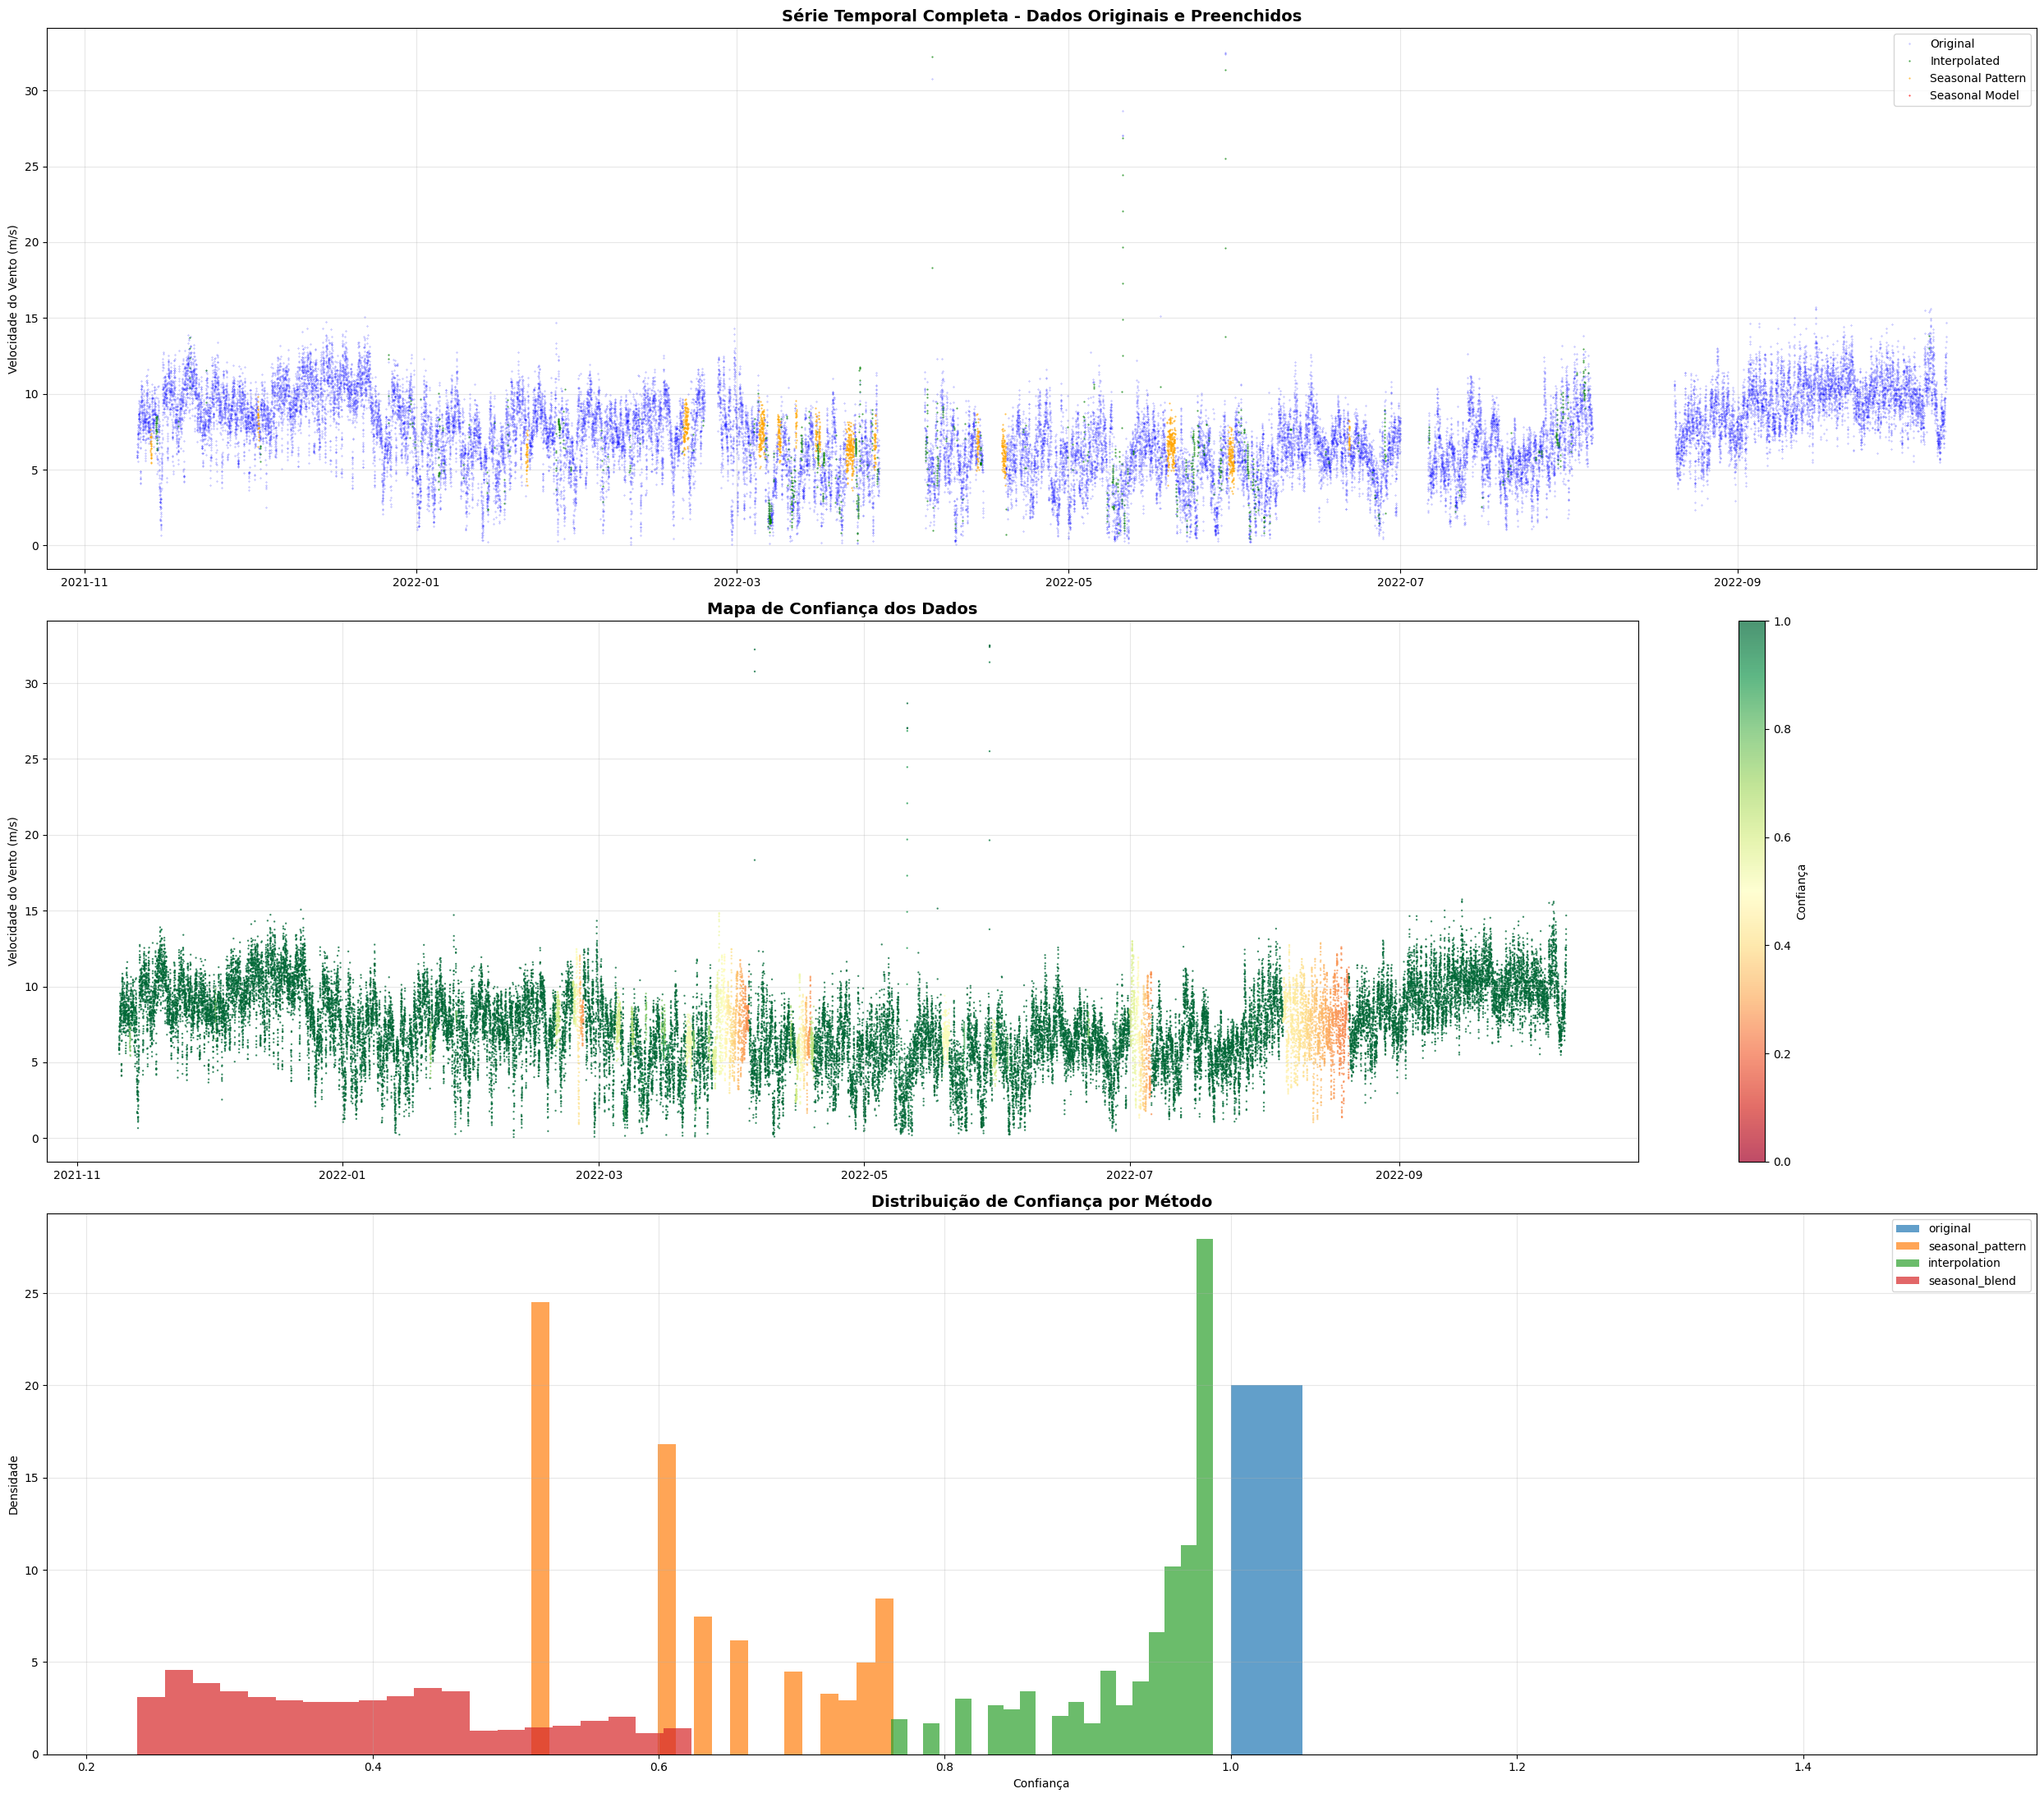


=== Análise de Qualidade ===
Confiança média: 0.926
Confiança mínima: 0.235
Dados com confiança >0.8: 41,598 (86.8%)
Dados com confiança >0.5: 43,899 (91.6%)
Dados com confiança >0.3: 46,683 (97.5%)


In [182]:
# Visualização dos resultados
fig, axes = plt.subplots(3, 1, figsize=(25, 22))

# 1. Série temporal completa com códigos de cores
original_mask = fill_methods == 'original'
interpolated_mask = fill_methods == 'interpolation'
seasonal_mask = fill_methods == 'seasonal_pattern'
model_mask = fill_methods == 'seasonal_model'

# Plot principal
axes[0].plot(filled_data.index[original_mask], filled_data[original_mask], 
            '.', color='blue', alpha=0.6, markersize=0.5, label='Original')
axes[0].plot(filled_data.index[interpolated_mask], filled_data[interpolated_mask], 
            '.', color='green', alpha=0.8, markersize=1, label='Interpolated')
axes[0].plot(filled_data.index[seasonal_mask], filled_data[seasonal_mask], 
            '.', color='orange', alpha=0.8, markersize=1, label='Seasonal Pattern')
axes[0].plot(filled_data.index[model_mask], filled_data[model_mask], 
            '.', color='red', alpha=0.8, markersize=1, label='Seasonal Model')

axes[0].set_title('Série Temporal Completa - Dados Originais e Preenchidos', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Velocidade do Vento (m/s)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Mapa de confiança
scatter = axes[1].scatter(filled_data.index, filled_data, c=confidence_scores, 
                         cmap='RdYlGn', alpha=0.7, s=0.5, vmin=0, vmax=1)
plt.colorbar(scatter, ax=axes[1], label='Confiança')
axes[1].set_title('Mapa de Confiança dos Dados', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Velocidade do Vento (m/s)')
axes[1].grid(True, alpha=0.3)

# 3. Distribuição de confiança por método
confidence_by_method = pd.DataFrame({
    'confidence': confidence_scores,
    'method': fill_methods
}).dropna()

methods = confidence_by_method['method'].unique()
for i, method in enumerate(methods):
    method_data = confidence_by_method[confidence_by_method['method'] == method]['confidence']
    axes[2].hist(method_data, bins=20, alpha=0.7, label=method, density=True)

axes[2].set_title('Distribuição de Confiança por Método', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Confiança')
axes[2].set_ylabel('Densidade')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas de qualidade
print(f"\n=== Análise de Qualidade ===")
print(f"Confiança média: {confidence_scores.mean():.3f}")
print(f"Confiança mínima: {confidence_scores.min():.3f}")
print(f"Dados com confiança >0.8: {(confidence_scores > 0.8).sum():,} ({(confidence_scores > 0.8).sum()/len(confidence_scores)*100:.1f}%)")
print(f"Dados com confiança >0.5: {(confidence_scores > 0.5).sum():,} ({(confidence_scores > 0.5).sum()/len(confidence_scores)*100:.1f}%)")
print(f"Dados com confiança >0.3: {(confidence_scores > 0.3).sum():,} ({(confidence_scores > 0.3).sum()/len(confidence_scores)*100:.1f}%)")

## 7. Salvar Dataset Unificado e Metadados

In [183]:
# Criar dataset final com metadados
final_dataset = pd.DataFrame({
    'SODAR-100': filled_data,
    'confidence': confidence_scores,
    'fill_method': fill_methods,
    'data_quality': pd.cut(confidence_scores, 
                          bins=[0, 0.3, 0.5, 0.8, 1.0], 
                          labels=['low', 'medium', 'high', 'original'])
})

# Salvar dataset principal
output_path = output_dir / "wind_data_unified_filled.csv"
final_dataset.to_csv(output_path)
print(f"✓ Dataset unificado salvo: {output_path}")

# Criar diferentes versões por qualidade
quality_versions = {
    'high_quality': final_dataset[final_dataset['confidence'] > 0.8],
    'medium_quality': final_dataset[final_dataset['confidence'] > 0.5],
    'all_filled': final_dataset
}

quality_info = []
for quality_level, data in quality_versions.items():
    filename = f"wind_data_{quality_level}.csv"
    filepath = output_dir / filename
    
    # Salvar apenas a coluna SODAR-100 para uso em ML
    ml_data = data[['SODAR-100']].copy()
    ml_data.to_csv(filepath)
    
    # Calcular estatísticas
    quality_info.append({
        'quality_level': quality_level,
        'filename': filename,
        'records': len(data),
        'completeness': len(data) / len(final_dataset) * 100,
        'avg_confidence': data['confidence'].mean(),
        'period_start': data.index[0],
        'period_end': data.index[-1],
        'continuous_periods': len([1 for g in classify_gaps(ml_data['SODAR-100']) if g['duration_hours'] > 4])
    })
    
    print(f"✓ {filename} salvo: {len(data):,} registros ({len(data)/len(final_dataset)*100:.1f}% dos dados)")

# Salvar metadados de qualidade
quality_df = pd.DataFrame(quality_info)
quality_df.to_csv(output_dir / "data_quality_summary.csv", index=False)
print(f"✓ Resumo de qualidade salvo: {output_dir / 'data_quality_summary.csv'}")

# Salvar informações de preenchimento
gap_fill_summary = {
    'original_records': (complete_timeline['data_source'] == 'original').sum(),
    'total_records': len(complete_timeline),
    'original_completeness': (complete_timeline['data_source'] == 'original').sum() / len(complete_timeline),
    'filled_by_interpolation': (fill_methods == 'interpolation').sum(),
    'filled_by_seasonal_pattern': (fill_methods == 'seasonal_pattern').sum(),
    'filled_by_seasonal_model': (fill_methods == 'seasonal_model').sum(),
    'final_completeness': (~filled_data.isna()).sum() / len(filled_data),
    'processing_date': datetime.now().isoformat()
}

import json
with open(output_dir / "gap_filling_metadata.json", 'w') as f:
    json.dump(gap_fill_summary, f, indent=2, default=str)

print(f"\n=== Arquivos Gerados ===")
for file in output_dir.glob("*"):
    size_mb = file.stat().st_size / (1024*1024)
    print(f"  {file.name}: {size_mb:.2f} MB")

✓ Dataset unificado salvo: ../clean_data/wind_data_unified_filled.csv
✓ Nenhum gap encontrado - série temporal completa
✓ wind_data_high_quality.csv salvo: 41,598 registros (86.8% dos dados)
✓ Nenhum gap encontrado - série temporal completa
✓ wind_data_medium_quality.csv salvo: 43,899 registros (91.6% dos dados)
✓ Nenhum gap encontrado - série temporal completa
✓ wind_data_all_filled.csv salvo: 47,900 registros (100.0% dos dados)
✓ Resumo de qualidade salvo: ../clean_data/data_quality_summary.csv

=== Arquivos Gerados ===
  wind_data_high_quality.csv: 1.00 MB
  wind_data_unified_filled.csv: 2.35 MB
  wind_data_all_filled.csv: 1.23 MB
  gap_filling_metadata.json: 0.00 MB
  data_quality_summary.csv: 0.00 MB
  ml_config.json: 0.00 MB
  high_quality_datasets.txt: 0.00 MB
  wind_data_medium_quality.csv: 1.08 MB


## 8. Recomendações para Uso em ML

In [184]:
print("=== RECOMENDAÇÕES PARA TREINAMENTO DE MODELOS ML ===")
print()
print("📊 DATASETS DISPONÍVEIS:")
print("  1. wind_data_high_quality.csv    - Apenas dados confiança >80% (para validação)")
print("  2. wind_data_medium_quality.csv  - Dados confiança >50% (treinamento robusto)")
print("  3. wind_data_all_filled.csv      - Todos os dados preenchidos (máximo volume)")
print()
print("🎯 ESTRATÉGIA RECOMENDADA:")
print("  • TREINAMENTO: Usar 'medium_quality' (confiança >50%)")
print("  • VALIDAÇÃO: Usar 'high_quality' (confiança >80%)")
print("  • TESTE: Usar apenas dados originais (confiança = 100%)")
print()
print("⚠️  CUIDADOS IMPORTANTES:")
print("  • Dados preenchidos têm menor variabilidade natural")
print("  • Considerar usar pesos baseados na confiança durante treinamento")
print("  • Validar modelos em períodos contínuos longos")
print("  • Monitorar performance em dados de diferentes qualidades")
print()
print("📈 FEATURES ADICIONAIS SUGERIDAS:")
print("  • Confiança do dado como feature")
print("  • Método de preenchimento como categoria")
print("  • Tempo desde último dado original")
print("  • Indicadores temporais (hora, dia da semana, estação)")

# Análise final de continuidade
print(f"\n=== ANÁLISE DE CONTINUIDADE FINAL ===")
for quality_level, data in quality_versions.items():
    ml_data = data[['SODAR-100']].dropna()
    gaps = classify_gaps(ml_data['SODAR-100'])
    large_gaps = [g for g in gaps if g['duration_hours'] > 4]
    
    if large_gaps:
        max_continuous = max((g['start'] - large_gaps[i-1]['end']).total_seconds() / 3600 
                           for i, g in enumerate(large_gaps[1:], 1))
        max_continuous = max(max_continuous, (large_gaps[0]['start'] - ml_data.index[0]).total_seconds() / 3600)
        max_continuous = max(max_continuous, (ml_data.index[-1] - large_gaps[-1]['end']).total_seconds() / 3600)
    else:
        max_continuous = (ml_data.index[-1] - ml_data.index[0]).total_seconds() / 3600
    
    print(f"  {quality_level}: {len(large_gaps)} gaps >4h, período contínuo máximo: {max_continuous:.1f}h")

print(f"\n🎉 PROCESSAMENTO CONCLUÍDO COM SUCESSO!")
print(f"✓ Dataset unificado criado com {len(final_dataset):,} pontos")
print(f"✓ Taxa de completude final: {(~filled_data.isna()).sum()/len(filled_data)*100:.1f}%")
print(f"✓ Arquivos salvos em: {output_dir}")

=== RECOMENDAÇÕES PARA TREINAMENTO DE MODELOS ML ===

📊 DATASETS DISPONÍVEIS:
  1. wind_data_high_quality.csv    - Apenas dados confiança >80% (para validação)
  2. wind_data_medium_quality.csv  - Dados confiança >50% (treinamento robusto)
  3. wind_data_all_filled.csv      - Todos os dados preenchidos (máximo volume)

🎯 ESTRATÉGIA RECOMENDADA:
  • TREINAMENTO: Usar 'medium_quality' (confiança >50%)
  • VALIDAÇÃO: Usar 'high_quality' (confiança >80%)
  • TESTE: Usar apenas dados originais (confiança = 100%)

⚠️  CUIDADOS IMPORTANTES:
  • Dados preenchidos têm menor variabilidade natural
  • Considerar usar pesos baseados na confiança durante treinamento
  • Validar modelos em períodos contínuos longos
  • Monitorar performance em dados de diferentes qualidades

📈 FEATURES ADICIONAIS SUGERIDAS:
  • Confiança do dado como feature
  • Método de preenchimento como categoria
  • Tempo desde último dado original
  • Indicadores temporais (hora, dia da semana, estação)

=== ANÁLISE DE CONTINU